### 1. Load and Display data and Checking for Missing Values

In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Row
import pandas as pd
from pyspark.sql.types import StringType, NumericType, BooleanType, TimestampType, DecimalType, ArrayType, StructType
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col, isnan, when, count

In [2]:
spark = SparkSession.builder \
    .appName("BasalamAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

df = spark.read.csv("/kaggle/input/basalam-comments-and-products/BaSalam.products.csv", header=True, inferSchema=True)

# Convert column names to a pandas DataFrame for table display
columns_df = spark.createDataFrame([Row(Column_Name=col_name) for col_name in df.columns])
columns_pd = columns_df.toPandas()

print("Columns in the Dataset:")
display(columns_pd)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 12:31:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Columns in the Dataset:


,Column_Name
0,_id
1,_score
2,sales_count_week
3,name
4,price
5,status_id
6,status_title
7,stock
8,photo_MEDIUM
9,photo_SMALL


In [3]:
# 1. Get numerical columns (int, float, double, etc.)
numerical_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# 2. Get categorical columns (string type)
categorical_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]

# 3. Get binary columns (only 2 distinct values, numeric or string)
binary_columns = []
for col_name in df.columns:
    try:
        unique_vals = df.select(col_name).distinct().limit(3).count()
        if unique_vals == 2:
            binary_columns.append(col_name)
    except:
        pass  # skip any column that throws an error

# 4. Get boolean columns
boolean_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, BooleanType)]

# 5. Get timestamp columns
timestamp_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, TimestampType)]

# 6. Get decimal columns
decimal_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, DecimalType)]

# 7. Get array columns
array_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, ArrayType)]

# 8. Get struct columns
struct_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, StructType)]

# 9. Display the results as tables for each column type
print("Numerical Columns:")
display(pd.DataFrame(numerical_columns, columns=["Numerical_Columns"]))

print("Categorical Columns:")
display(pd.DataFrame(categorical_columns, columns=["Categorical_Columns"]))

print("Binary Columns:")
display(pd.DataFrame(binary_columns, columns=["Binary_Columns"]))

print("Boolean Columns:")
display(pd.DataFrame(boolean_columns, columns=["Boolean_Columns"]))

print("Timestamp Columns:")
display(pd.DataFrame(timestamp_columns, columns=["Timestamp_Columns"]))

print("Decimal Columns:")
display(pd.DataFrame(decimal_columns, columns=["Decimal_Columns"]))

print("Array Columns:")
display(pd.DataFrame(array_columns, columns=["Array_Columns"]))

print("Struct Columns:")
display(pd.DataFrame(struct_columns, columns=["Struct_Columns"]))

Numerical Columns:


,Numerical_Columns
0,_id
1,_score
2,sales_count_week
3,price
4,status_id
5,stock
6,rating_average
7,rating_count
8,rating_signals
9,primaryPrice


Categorical Columns:


,Categorical_Columns
0,name
1,status_title
2,photo_MEDIUM
3,photo_SMALL
4,vendor_name
5,vendor_identifier
6,vendor_status_title
7,vendor_owner_city
8,mainAttribute
9,categoryTitle


Binary Columns:


,Binary_Columns
0,status_title


Boolean Columns:


,Boolean_Columns
0,has_delivery
1,has_variation
2,vendor_has_delivery
3,isFreeShipping
4,IsAvailable
5,IsSaleable
6,published


Timestamp Columns:


,Timestamp_Columns


Decimal Columns:


,Decimal_Columns


Array Columns:


,Array_Columns


Struct Columns:


,Struct_Columns


In [4]:
# Step 1: Extract column names and their corresponding data types
column_types = [(f.name, str(f.dataType)) for f in df.schema.fields]

# Step 2: Convert to pandas DataFrame
column_types_df = pd.DataFrame(column_types, columns=["Column_Name", "Data_Type"])

# Step 3: Group columns by their data types
grouped_columns = column_types_df.groupby("Data_Type")["Column_Name"].apply(list).reset_index()

# Step 4: Display the result in a table
display(grouped_columns)

,Data_Type,Column_Name
0,BooleanType(),"[has_delivery, has_variation, vendor_has_deliv..."
1,DoubleType(),"[_score, rating_average]"
2,IntegerType(),"[_id, sales_count_week, price, status_id, stoc..."
3,StringType(),"[name, status_title, photo_MEDIUM, photo_SMALL..."


In [5]:
# Run describe only on numerical columns and convert to Pandas
numeric_stats = df.select(numerical_columns).describe().toPandas()

print("Summary Statistics for Numerical Columns:")
display(numeric_stats)

25/04/28 12:39:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Summary Statistics for Numerical Columns:


,summary,_id,_score,sales_count_week,price,status_id,stock,rating_average,rating_count,rating_signals,...,navigation_id,vendor_statusId,vendor_freeShippingToIran,vendor_freeShippingToSameCity,vendor_cityId,vendor_provinceId,vendor_score,vendor_id,vendor_status_id,vendor_owner_id
0,count,2411358,2411358,2411358,2411356,2411356,2411356,2411355,2411355,2411355,...,48226,2411355,1742028,1624462,2411355,2411355,1171818,2411355,2411355,2411355
1,mean,8597589.141956525,69.34688429883539,0.043767868562030195,9263276.288979728,2976.8719417622283,32907.0406592805,1.4855676994884555,1.8926437625318544,1.8926437625318544,...,319.3239124123917,2987.000376137068,1.8928645567940928E7,1.200753992478556E7,2221.1026609520372,13.971001366451642,0.4525916140561077,505573.3472533078,2987.000376137068,6273908.150367324
2,stddev,3402083.73473064,94.1673091389762,0.3214209540235807,3.438397326028527E7,26.627065291595756,4933175.676261697,2.1954467852079502,15.00858522542236,15.00858522542236,...,879.9023492307176,0.019390609711578684,6.3413044437709644E7,4.8504848830031075E7,321.5811094740018,7.813284836195351,0.49774758298567345,263082.1987844294,0.019390609711578684,4589965.069693647
3,min,20276,0.0,0,10000,2976,0,0.0,0,0,...,1,2987,0,0,1722,3,0,7,2987,11
4,max,13445061,491.3793,56,999999990,3790,1000000000,5.0,4488,4488,...,9982,2988,999999990,999999990,2967,33,1,967729,2988,15825531


In [6]:
# Count null values in each column
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# Convert to pandas for easy display
null_counts_pd = null_counts.toPandas()

# Display the result
print("Null Counts for Each Column:")
display(null_counts_pd)

Null Counts for Each Column:


,_id,_score,sales_count_week,name,price,status_id,status_title,stock,photo_MEDIUM,photo_SMALL,...,vendor_owner_city,vendor_owner_id,isFreeShipping,IsAvailable,IsSaleable,mainAttribute,categoryTitle,published,video_ORIGINAL,promotions
0,0,0,0,8,2,2,2585,2,540,540,...,7,3,3,3,3,2213550,46,2341306,2254969,2411289


#### Plot Histograms for Numerical Columns:

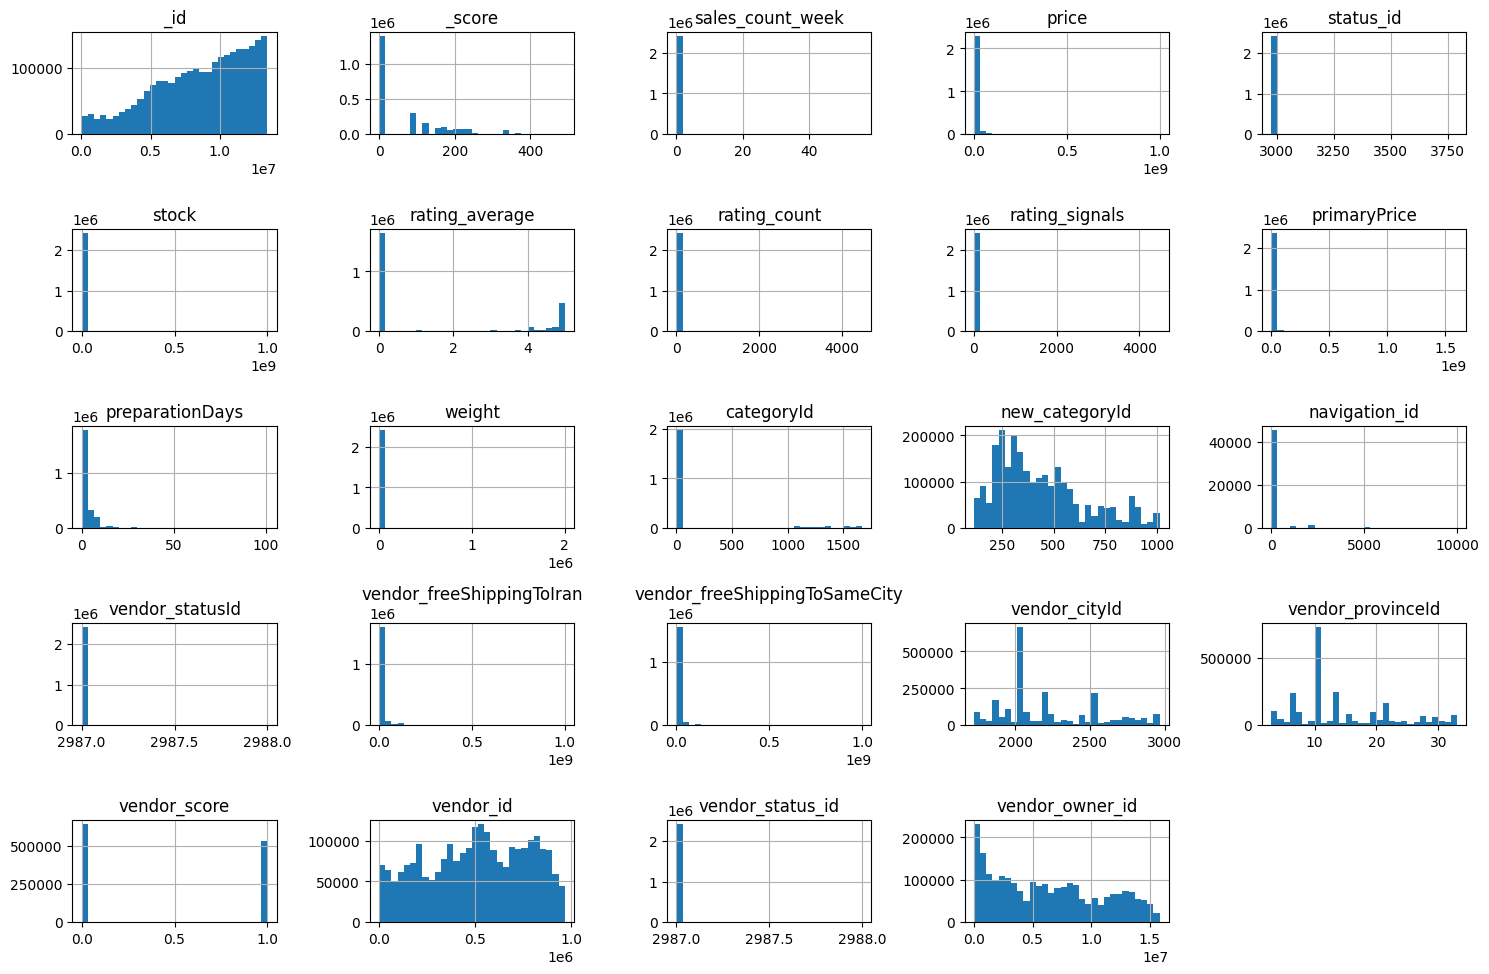

In [7]:
import matplotlib.pyplot as plt

# Step 1: Convert the numerical columns of the PySpark DataFrame to a pandas DataFrame
df_pandas = df.select(numerical_columns).toPandas()

# Step 2: Plot histograms for each numerical column
df_pandas.hist(bins=30, figsize=(15, 10))

# Step 3: Adjust layout for a cleaner display
plt.tight_layout()

# Step 4: Show the plot
plt.show()

### Filtering columns with high percent of missing values

In [8]:
from pyspark.sql.functions import col, count, when

# Total number of rows
total_rows = df.count()

# Initialize an empty list to collect final column names
final_cols = []
nan_threshold=0.2
# Loop over the correlated columns
for c in df.columns:
    missing_count = df.select(
        count(when(col(c).isNull(), c)).alias("missing")
    ).collect()[0]["missing"]
    
    missing_percent = missing_count / total_rows
    
    if missing_percent <= nan_threshold:
        final_cols.append(c)
print(final_cols)

['_id', '_score', 'sales_count_week', 'name', 'price', 'status_id', 'status_title', 'stock', 'photo_MEDIUM', 'photo_SMALL', 'rating_average', 'rating_count', 'rating_signals', 'primaryPrice', 'preparationDays', 'weight', 'categoryId', 'has_delivery', 'has_variation', 'new_categoryId', 'vendor_name', 'vendor_identifier', 'vendor_statusId', 'vendor_cityId', 'vendor_provinceId', 'vendor_has_delivery', 'vendor_id', 'vendor_status_id', 'vendor_status_title', 'vendor_owner_city', 'vendor_owner_id', 'isFreeShipping', 'IsAvailable', 'IsSaleable', 'categoryTitle']


In [9]:
df = df.select(final_cols)
df.printSchema()
print(len(df.columns))

root
 |-- _id: integer (nullable = true)
 |-- _score: double (nullable = true)
 |-- sales_count_week: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- status_id: integer (nullable = true)
 |-- status_title: string (nullable = true)
 |-- stock: integer (nullable = true)
 |-- photo_MEDIUM: string (nullable = true)
 |-- photo_SMALL: string (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- rating_count: integer (nullable = true)
 |-- rating_signals: integer (nullable = true)
 |-- primaryPrice: integer (nullable = true)
 |-- preparationDays: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- has_delivery: boolean (nullable = true)
 |-- has_variation: boolean (nullable = true)
 |-- new_categoryId: integer (nullable = true)
 |-- vendor_name: string (nullable = true)
 |-- vendor_identifier: string (nullable = true)
 |-- vendor_statusId: integer (nullable = tr

### Data split 

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Step 2: Choose your target column
target = "_score"  # Replace with the actual target column name

# Step 3: Drop rows with null in target (optional but common)
df = df.filter(col(target).isNotNull())

# Step 5: Split into train (80%) and test (20%)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Step 7: Show counts
print("Train set count:", train_df.count())
print("Test set count:", test_df.count())

Train set count: 1929295


Test set count: 482063


### Preprocessing needed for any dataframe
#### Handling missing values in numerical and categorical columns after we have filtered columns with high perecent of missing

In [11]:
# Example: Remove specific columns by name
columns_to_remove = ['_id','photo_MEDIUM','vendor_identifier', 'photo_SMALL','vendor_id','vendor_provinceId','vendor_owner_id','vendor_status_id','vendor_cityId','vendor_statusId','categoryId','new_categoryId','status_id']
for column in columns_to_remove:
    if column in final_cols:
        final_cols.remove(column)

In [12]:
from pyspark.sql.types import DoubleType, IntegerType, BooleanType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count

def preprocess(df,final_cols):
    print("Number of columns:",len(train_df.columns),"Columns:")
    # df.printSchema()
    train_df_pd = train_df.toPandas()
    display(train_df_pd)


    # Step 1: Copy DataFrame
    df_temp = df.select(*final_cols)
    
    # Step 2: Fill numeric NaNs with median only for final_cols
    numeric_cols = [
        f.name for f in df_temp.schema.fields 
        if isinstance(f.dataType, (DoubleType, IntegerType)) and f.name in final_cols
    ]
    
    for column_name in numeric_cols:
        median_val = df_temp.approxQuantile(column_name, [0.5], 0.01)[0]
        if median_val is not None:
            df_temp = df_temp.fillna({column_name: median_val})
    
    # Step 3: Fill categorical NaNs with mode only for final_cols
    categorical_cols = [
        f.name for f in df_temp.schema.fields 
        if f.dataType == F.StringType() and f.name in final_cols
    ]
    
    for column_name in categorical_cols:
        # groupBy(...).count().orderBy(...).first() gives the most frequent value (mode).
        mode_row = df_temp.groupBy(column_name).count().orderBy(F.desc("count")).first()
        if mode_row:
            mode_val = mode_row[column_name]
            df_temp = df_temp.fillna({column_name: mode_val})

    # Step 4: Fill Boolean NaNs with mode
    boolean_cols = [
        f.name for f in df_temp.schema.fields 
        if isinstance(f.dataType, BooleanType) and f.name in final_cols
    ]
    
    for column_name in boolean_cols:
        mode_row = df_temp.groupBy(column_name).count().orderBy(F.desc("count")).first()
        if mode_row:
            mode_val = mode_row[column_name]
            print(f"Boolean column: {column_name}, mode: {mode_val}")
            df_temp = df_temp.fillna({column_name: mode_val})

    # Step 5: Checking for nulls after handling
    # Count null values in each column
    null_counts = df_temp.select([count(when(col(column).isNull(), column)).alias(column) for column in final_cols])
    
    # Convert to pandas for easy display
    null_counts_pd = null_counts.toPandas()
    
    # Display the result
    print("Null Counts for Each Column:")
    display(null_counts_pd)
    
    return df_temp

In [13]:
from pyspark.sql.types import DoubleType, IntegerType, BooleanType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count

def preprocess_test(df,final_cols):
    # Step 1: Copy DataFrame
    df_temp = df.select(*final_cols)
    
    # Step 2: Fill numeric NaNs with median only for final_cols
    numeric_cols = [
        f.name for f in df_temp.schema.fields 
        if isinstance(f.dataType, (DoubleType, IntegerType)) and f.name in final_cols
    ]
    
    for column_name in numeric_cols:
        median_val = df_temp.approxQuantile(column_name, [0.5], 0.01)[0]
        if median_val is not None:
            df_temp = df_temp.fillna({column_name: median_val})
    
    # Step 3: Fill categorical NaNs with mode only for final_cols
    categorical_cols = [
        f.name for f in df_temp.schema.fields 
        if f.dataType == F.StringType() and f.name in final_cols
    ]
    
    for column_name in categorical_cols:
        # groupBy(...).count().orderBy(...).first() gives the most frequent value (mode).
        mode_row = df_temp.groupBy(column_name).count().orderBy(F.desc("count")).first()
        if mode_row:
            mode_val = mode_row[column_name]
            df_temp = df_temp.fillna({column_name: mode_val})

    # Step 4: Fill Boolean NaNs with mode
    boolean_cols = [
        f.name for f in df_temp.schema.fields 
        if isinstance(f.dataType, BooleanType) and f.name in final_cols
    ]
    
    for column_name in boolean_cols:
        mode_row = df_temp.groupBy(column_name).count().orderBy(F.desc("count")).first()
        if mode_row:
            mode_val = mode_row[column_name]
            print(f"Boolean column: {column_name}, mode: {mode_val}")
            df_temp = df_temp.fillna({column_name: mode_val})

    # Step 5: Checking for nulls after handling
    # Count null values in each column
    null_counts = df_temp.select([count(when(col(column).isNull(), column)).alias(column) for column in final_cols])
    
    # Convert to pandas for easy display
    null_counts_pd = null_counts.toPandas()
    
    # Display the result
    print("Null Counts for Each Column:")
    display(null_counts_pd)

    df_temp.printSchema()
    # Step 1: Index + Encode
    indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_cols]
    encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_ohe", dropLast=True) for col in categorical_cols]
    pipeline = Pipeline(stages=indexers + encoders)
    df_temp = pipeline.fit(df_temp).transform(df_temp)
    
    # Step 2: Convert vector column to array and then to individual binary columns
    for cat_col in categorical_cols:
        ohe_col = cat_col + "_ohe"
        arr_col = cat_col + "_arr"
        
        # Convert vector to array
        df_temp = df_temp.withColumn(arr_col, vector_to_array(ohe_col))
        
        # Determine the number of binary columns
        ohe_size = df_temp.select(arr_col).head()[0].__len__()
    
        # Create binary columns
        for i in range(ohe_size):
            df_temp = df_temp.withColumn(f"{cat_col}_{i}", col(arr_col)[i])
        
        # Drop intermediate columns
        df_temp = df_temp.drop(cat_col,cat_col + "_index", ohe_col, arr_col)
    
    return df_temp

### Preparing for train

In [14]:
train_df=preprocess(train_df,final_cols)

Number of columns: 35 Columns:


,_id,_score,sales_count_week,name,price,status_id,status_title,stock,photo_MEDIUM,photo_SMALL,...,vendor_has_delivery,vendor_id,vendor_status_id,vendor_status_title,vendor_owner_city,vendor_owner_id,isFreeShipping,IsAvailable,IsSaleable,categoryTitle
0,20276,243.75000,0,مرکب 8 پیامبر اکرم (ص) سبک زندگی و طب اسلامی شیعی,400000.0,2976.0,در دسترس,19.0,https://statics.basalam.com/public-3/users/WAJ...,https://statics.basalam.com/public-3/users/WAJ...,...,True,250.0,2987.0,فعال,قم,1130.0,False,True,True,داروهای گیاهی
1,20400,333.33334,1,نان هسته خرما فلاوینا- حاوی سبوس گندم و پودر ه...,440000.0,2976.0,در دسترس,9896.0,https://statics.basalam.com/public-3/users/mzB...,https://statics.basalam.com/public-3/users/mzB...,...,True,147.0,2987.0,فعال,اصفهان,52148.0,False,True,True,نان
2,20459,244.25287,0,مرکب 7 (شافیه)22 ماهه - سبک زندگی و طب اسلامی ...,500000.0,2976.0,در دسترس,4.0,https://statics.basalam.com/public-3/users/WAJ...,https://statics.basalam.com/public-3/users/WAJ...,...,True,250.0,2987.0,فعال,قم,1130.0,False,True,True,داروهای گیاهی
3,20531,333.33334,1,قهوه هسته خرما برکت 200 گرمی,172000.0,2976.0,در دسترس,117.0,https://statics.basalam.com/public-3/users/grr...,https://statics.basalam.com/public-3/users/grr...,...,True,417.0,2987.0,فعال,تهران,1800.0,False,True,True,قهوه
4,20588,245.86777,0,پودر گیاه کارلا (500 گرمی),2400000.0,2976.0,در دسترس,42.0,https://statics.basalam.com/public-3/users/E3m...,https://statics.basalam.com/public-3/users/E3m...,...,True,345.0,2987.0,فعال,اصفهان,1562.0,False,True,True,گیاهان دارویی
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929290,13432498,0.00000,0,باتری گوشی LG مدل G4,3355000.0,2976.0,در دسترس,2.0,https://statics.basalam.com/public-18/users/70...,https://statics.basalam.com/public-18/users/70...,...,True,651930.0,2987.0,فعال,تهران,10919778.0,False,True,True,باتری گوشی موبایل
1929291,13432509,0.00000,0,و یپ پا د گیک و یپ ساندر یو,8000000.0,2976.0,در دسترس,2.0,https://statics.basalam.com/public-18/users/38...,https://statics.basalam.com/public-18/users/38...,...,True,840698.0,2987.0,فعال,نجف آباد,13925365.0,False,True,True,پخش‌کننده MP3 و MP4
1929292,13432609,0.00000,0,باتری گوشی ایفون 5S,6150000.0,2976.0,در دسترس,2.0,https://statics.basalam.com/public-18/users/70...,https://statics.basalam.com/public-18/users/70...,...,True,651930.0,2987.0,فعال,تهران,10919778.0,False,True,True,باتری گوشی موبایل
1929293,13432674,0.00000,0,باتری گوشی آیفون 4S,3990000.0,2976.0,در دسترس,2.0,https://statics.basalam.com/public-18/users/70...,https://statics.basalam.com/public-18/users/70...,...,True,651930.0,2987.0,فعال,تهران,10919778.0,False,True,True,باتری گوشی موبایل


Boolean column: has_delivery, mode: True


Boolean column: has_variation, mode: False


Boolean column: vendor_has_delivery, mode: True


Boolean column: isFreeShipping, mode: False


Boolean column: IsAvailable, mode: True


Boolean column: IsSaleable, mode: True


Null Counts for Each Column:


,_score,sales_count_week,name,price,status_title,stock,rating_average,rating_count,rating_signals,primaryPrice,...,has_delivery,has_variation,vendor_name,vendor_has_delivery,vendor_status_title,vendor_owner_city,isFreeShipping,IsAvailable,IsSaleable,categoryTitle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType
# The warning in output:
# It's usually harmless and just a debugging message from Spark’s memory manager saying:
# “I thought I might need to spill, but turns out there's nothing large enough or it’s unnecessary now.”
print(final_cols)
# Step 1: Identify categorical columns from final_cols
categorical_cols = [
    f.name for f in train_df.schema.fields 
    if isinstance(f.dataType, StringType) and f.name in final_cols
]
print(categorical_cols)
# Step 2: Print unique value counts
for col in categorical_cols:
    unique_count = train_df.select(col).distinct().count()
    print(f"{col}: {unique_count} unique values")

# Step 3: Drop high-cardinality columns (e.g., > 100 unique values)
high_card_cols = [
    col for col in categorical_cols 
    if train_df.select(col).distinct().count() > 10
]
print("Dropping these high-cardinality columns:", high_card_cols)

# Update categorical_cols by removing dropped ones
categorical_cols = [col for col in categorical_cols if col not in high_card_cols]
train_df = train_df.drop(*high_card_cols)

print(train_df.columns)

['_score', 'sales_count_week', 'name', 'price', 'status_title', 'stock', 'rating_average', 'rating_count', 'rating_signals', 'primaryPrice', 'preparationDays', 'weight', 'has_delivery', 'has_variation', 'vendor_name', 'vendor_has_delivery', 'vendor_status_title', 'vendor_owner_city', 'isFreeShipping', 'IsAvailable', 'IsSaleable', 'categoryTitle']
['name', 'status_title', 'vendor_name', 'vendor_status_title', 'vendor_owner_city', 'categoryTitle']


name: 1839084 unique values


status_title: 1 unique values


vendor_name: 86757 unique values


vendor_status_title: 2 unique values


vendor_owner_city: 984 unique values


categoryTitle: 813 unique values


Dropping these high-cardinality columns: ['name', 'vendor_name', 'vendor_owner_city', 'categoryTitle']
['_score', 'sales_count_week', 'price', 'status_title', 'stock', 'rating_average', 'rating_count', 'rating_signals', 'primaryPrice', 'preparationDays', 'weight', 'has_delivery', 'has_variation', 'vendor_has_delivery', 'vendor_status_title', 'isFreeShipping', 'IsAvailable', 'IsSaleable']


In [16]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# Step 1: Index + Encode
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_ohe", dropLast=True) for col in categorical_cols]
pipeline = Pipeline(stages=indexers + encoders)
train_df = pipeline.fit(train_df).transform(train_df)

# Step 2: Convert vector column to array and then to individual binary columns
print(categorical_cols)
for cat_col in categorical_cols:
    ohe_col = cat_col + "_ohe"
    arr_col = cat_col + "_arr"
    
    # Convert vector to array
    train_df = train_df.withColumn(arr_col, vector_to_array(ohe_col))
    
    # Determine the number of binary columns
    ohe_size = train_df.select(arr_col).head()[0].__len__()

    # Create binary columns
    for i in range(ohe_size):
        train_df = train_df.withColumn(f"{cat_col}_{i}", col(arr_col)[i])
    
    # Drop intermediate columns
    train_df = train_df.drop(cat_col,cat_col + "_index", ohe_col, arr_col)

['status_title', 'vendor_status_title']


### Calculate correlation with the target

In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import stddev, col
from pyspark.sql.types import DoubleType, IntegerType, BooleanType
print("Number of columns:",len(train_df.columns),"Columns:")
train_df.printSchema()
# Step 1: Identify all numeric columns (including Integer and Boolean)
numeric_cols = [
    f.name for f in train_df.schema.fields
    if isinstance(f.dataType, (DoubleType, IntegerType, BooleanType))
]

print("Number of columns:",len(numeric_cols),"All numeric columns:", numeric_cols)

# Step 2: Convert Boolean columns to Integer (True/False → 1/0)
for col_name in numeric_cols:
    if isinstance(train_df.schema[col_name].dataType, BooleanType):
        train_df = train_df.withColumn(col_name, col(col_name).cast("integer"))

# Step 3: Remove constant columns
constant_cols = []
for col_name in numeric_cols:
    std_dev = train_df.select(stddev(col_name)).collect()[0][0]
    if std_dev == 0 or std_dev is None:
        constant_cols.append(col_name)

numeric_cols = [col for col in numeric_cols if col not in constant_cols]
print("After removing constant columns:", numeric_cols)

# Step 4: Compute correlation
correlation_data = []
for col_name in numeric_cols:
    correlation = train_df.stat.corr(col_name, '_score')
    correlation_data.append({'Column': col_name, 'Correlation': correlation})

# Step 5: Convert to Pandas DataFrame and display
correlation_df = pd.DataFrame(correlation_data)
display(correlation_df)  # Show all correlations

# Step 6: Filter and display correlations above threshold
threshold = 0.1
filtered_df = correlation_df[correlation_df['Correlation'].abs() >= threshold]
print(f"\nColumns with correlation ≥ {threshold} with '_score':")
display(filtered_df)

Number of columns: 19 Columns:
root
 |-- _score: double (nullable = false)
 |-- sales_count_week: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- stock: integer (nullable = true)
 |-- rating_average: double (nullable = false)
 |-- rating_count: integer (nullable = true)
 |-- rating_signals: integer (nullable = true)
 |-- primaryPrice: integer (nullable = true)
 |-- preparationDays: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- has_delivery: boolean (nullable = false)
 |-- has_variation: boolean (nullable = false)
 |-- vendor_has_delivery: boolean (nullable = false)
 |-- isFreeShipping: boolean (nullable = false)
 |-- IsAvailable: boolean (nullable = false)
 |-- IsSaleable: boolean (nullable = false)
 |-- status_title_0: double (nullable = true)
 |-- vendor_status_title_0: double (nullable = true)
 |-- vendor_status_title_1: double (nullable = true)

Number of columns: 19 All numeric columns: ['_score', 'sales_count_week', 'price', 'stock', '

After removing constant columns: ['_score', 'sales_count_week', 'price', 'stock', 'rating_average', 'rating_count', 'rating_signals', 'primaryPrice', 'preparationDays', 'weight', 'has_delivery', 'has_variation', 'vendor_has_delivery', 'isFreeShipping', 'IsAvailable', 'IsSaleable', 'vendor_status_title_0', 'vendor_status_title_1']


,Column,Correlation
0,_score,1.000000
1,sales_count_week,0.424542
2,price,-0.116870
3,stock,-0.000086
4,rating_average,0.743488
5,rating_count,0.244015
6,rating_signals,0.244015
7,primaryPrice,-0.085388
8,preparationDays,0.016529
9,weight,-0.046133



Columns with correlation ≥ 0.1 with '_score':


,Column,Correlation
0,_score,1.000000
1,sales_count_week,0.424542
2,price,-0.116870
4,rating_average,0.743488
5,rating_count,0.244015
6,rating_signals,0.244015


In [18]:
final_cols = filtered_df['Column'].tolist()
print("Final selected columns:", final_cols)

Final selected columns: ['_score', 'sales_count_week', 'price', 'rating_average', 'rating_count', 'rating_signals']


In [19]:
# final_cols = ['sales_count_week', 'price', 'rating_average', '_score']

In [20]:
test_df=preprocess_test(test_df,final_cols)

Null Counts for Each Column:


,_score,sales_count_week,price,rating_average,rating_count,rating_signals
0,0,0,0,0,0,0


root
 |-- _score: double (nullable = false)
 |-- sales_count_week: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- rating_average: double (nullable = false)
 |-- rating_count: integer (nullable = true)
 |-- rating_signals: integer (nullable = true)



In [21]:
# Assemble the features into a vector
interaction_assembler = VectorAssembler(inputCols=['sales_count_week', 'price', 'rating_average'], outputCol="features")
train_df = interaction_assembler.transform(train_df)

In [22]:
interaction_assembler = VectorAssembler(inputCols=['sales_count_week', 'price', 'rating_average'], outputCol="features")
test_df = interaction_assembler.transform(test_df)

### Linear Regression with MapReduce

In [23]:
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Define Linear Regression Model
lr = LinearRegression(
    featuresCol="features", 
    labelCol="_score", 
    regParam=0.1, 
    elasticNetParam=0.1, 
    maxIter=50
)

# Fit the model on training data
lr_model = lr.fit(train_df)

# Step 6: Predict on both train and test
train_predictions = lr_model.transform(train_df)
test_predictions = lr_model.transform(test_df)

# Step 7: Evaluate

evaluator = RegressionEvaluator(labelCol="_score", predictionCol="prediction")

rmse_train = evaluator.setMetricName("rmse").evaluate(train_predictions)
mse_train = evaluator.setMetricName("mse").evaluate(train_predictions)
r2_train = evaluator.setMetricName("r2").evaluate(train_predictions)

rmse_test = evaluator.setMetricName("rmse").evaluate(test_predictions)
mse_test = evaluator.setMetricName("mse").evaluate(test_predictions)
r2_test = evaluator.setMetricName("r2").evaluate(test_predictions)

# Step 8: Print Results
print("📊 Train Metrics:")
print(f"  RMSE: {rmse_train}")
print(f"  MSE: {mse_train}")
print(f"  R2 : {r2_train}")

print("📈 Test Metrics:")
print(f"  RMSE: {rmse_test}")
print(f"  MSE: {mse_test}")
print(f"  R2 : {r2_test}")

📊 Train Metrics:
  RMSE: 54.39743725282892
  MSE: 2959.08117967546
  R2 : 0.666214272079593
📈 Test Metrics:
  RMSE: 54.53388447990783
  MSE: 2973.9445564679327
  R2 : 0.6649661539489746


In [24]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="_score", numTrees=100)
rf_model = rf.fit(train_df)

train_predictions = rf_model.transform(train_df)
test_predictions = rf_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="_score", predictionCol="prediction")

rmse_train = evaluator.setMetricName("rmse").evaluate(train_predictions)
mse_train = evaluator.setMetricName("mse").evaluate(train_predictions)
r2_train = evaluator.setMetricName("r2").evaluate(train_predictions)

rmse_test = evaluator.setMetricName("rmse").evaluate(test_predictions)
mse_test = evaluator.setMetricName("mse").evaluate(test_predictions)
r2_test = evaluator.setMetricName("r2").evaluate(test_predictions)

# Step 8: Print Results
print("📊 Train Metrics:")
print(f"  RMSE: {rmse_train}")
print(f"  MSE: {mse_train}")
print(f"  R2 : {r2_train}")

print("📈 Test Metrics:")
print(f"  RMSE: {rmse_test}")
print(f"  MSE: {mse_test}")
print(f"  R2 : {r2_test}")

📊 Train Metrics:
  RMSE: 45.84493597117639
  MSE: 2101.7581542012626
  R2 : 0.762920706524969
📈 Test Metrics:
  RMSE: 45.768916231066406
  MSE: 2094.793692966374
  R2 : 0.764008113025653


In [25]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol="features", labelCol="_score")
dt_model = dt.fit(train_df)

train_predictions = dt_model.transform(train_df)
test_predictions = dt_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="_score", predictionCol="prediction")

rmse_train = evaluator.setMetricName("rmse").evaluate(train_predictions)
mse_train = evaluator.setMetricName("mse").evaluate(train_predictions)
r2_train = evaluator.setMetricName("r2").evaluate(train_predictions)

rmse_test = evaluator.setMetricName("rmse").evaluate(test_predictions)
mse_test = evaluator.setMetricName("mse").evaluate(test_predictions)
r2_test = evaluator.setMetricName("r2").evaluate(test_predictions)

# Step 8: Print Results
print("📊 Train Metrics:")
print(f"  RMSE: {rmse_train}")
print(f"  MSE: {mse_train}")
print(f"  R2 : {r2_train}")

print("📈 Test Metrics:")
print(f"  RMSE: {rmse_test}")
print(f"  MSE: {mse_test}")
print(f"  R2 : {r2_test}")

📊 Train Metrics:
  RMSE: 41.52282887856914
  MSE: 1724.1453180789358
  R2 : 0.8055156093761993
📈 Test Metrics:
  RMSE: 41.37670909948076
  MSE: 1712.032055903054
  R2 : 0.8071286557765963


In [26]:
from pyspark.ml.regression import GeneralizedLinearRegression

glr = GeneralizedLinearRegression(featuresCol="features", labelCol="_score", family="gaussian", link="identity")
glr_model = glr.fit(train_df)

train_predictions = glr_model.transform(train_df)
test_predictions = glr_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="_score", predictionCol="prediction")

rmse_train = evaluator.setMetricName("rmse").evaluate(train_predictions)
mse_train = evaluator.setMetricName("mse").evaluate(train_predictions)
r2_train = evaluator.setMetricName("r2").evaluate(train_predictions)

rmse_test = evaluator.setMetricName("rmse").evaluate(test_predictions)
mse_test = evaluator.setMetricName("mse").evaluate(test_predictions)
r2_test = evaluator.setMetricName("r2").evaluate(test_predictions)

# Step 8: Print Results
print("📊 Train Metrics:")
print(f"  RMSE: {rmse_train}")
print(f"  MSE: {mse_train}")
print(f"  R2 : {r2_train}")

print("📈 Test Metrics:")
print(f"  RMSE: {rmse_test}")
print(f"  MSE: {mse_test}")
print(f"  R2 : {r2_test}")

25/04/28 13:23:09 WARN Instrumentation: [cb3dccc8] regParam is zero, which might cause numerical instability and overfitting.


📊 Train Metrics:
  RMSE: 54.39737921107757
  MSE: 2959.0748650337746
  R2 : 0.6662149843741005
📈 Test Metrics:
  RMSE: 54.533800446936915
  MSE: 2973.935391186337
  R2 : 0.6649671864764763


In [27]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="_score", maxIter=100)
gbt_model = gbt.fit(train_df)

train_predictions = gbt_model.transform(train_df)
test_predictions = gbt_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="_score", predictionCol="prediction")

rmse_train = evaluator.setMetricName("rmse").evaluate(train_predictions)
mse_train = evaluator.setMetricName("mse").evaluate(train_predictions)
r2_train = evaluator.setMetricName("r2").evaluate(train_predictions)

rmse_test = evaluator.setMetricName("rmse").evaluate(test_predictions)
mse_test = evaluator.setMetricName("mse").evaluate(test_predictions)
r2_test = evaluator.setMetricName("r2").evaluate(test_predictions)

# Step 8: Print Results
print("📊 Train Metrics:")
print(f"  RMSE: {rmse_train}")
print(f"  MSE: {mse_train}")
print(f"  R2 : {r2_train}")

print("📈 Test Metrics:")
print(f"  RMSE: {rmse_test}")
print(f"  MSE: {mse_test}")
print(f"  R2 : {r2_test}")

📊 Train Metrics:
  RMSE: 40.90061291917576
  MSE: 1672.860137164247
  R2 : 0.8113006015422529
📈 Test Metrics:
  RMSE: 40.763963895916774
  MSE: 1661.7007525076065
  R2 : 0.8127987985224198


In [28]:
from pyspark.ml.regression import IsotonicRegression

ir = IsotonicRegression(featuresCol="features", labelCol="_score")
ir_model = ir.fit(train_df)
train_predictions = ir_model.transform(train_df)
test_predictions = ir_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="_score", predictionCol="prediction")

rmse_train = evaluator.setMetricName("rmse").evaluate(train_predictions)
mse_train = evaluator.setMetricName("mse").evaluate(train_predictions)
r2_train = evaluator.setMetricName("r2").evaluate(train_predictions)

rmse_test = evaluator.setMetricName("rmse").evaluate(test_predictions)
mse_test = evaluator.setMetricName("mse").evaluate(test_predictions)
r2_test = evaluator.setMetricName("r2").evaluate(test_predictions)

# Step 8: Print Results
print("📊 Train Metrics:")
print(f"  RMSE: {rmse_train}")
print(f"  MSE: {mse_train}")
print(f"  R2 : {r2_train}")

print("📈 Test Metrics:")
print(f"  RMSE: {rmse_test}")
print(f"  MSE: {mse_test}")
print(f"  R2 : {r2_test}")

📊 Train Metrics:
  RMSE: 79.70803273913313
  MSE: 6353.370483142719
  R2 : 0.2833368661766804
📈 Test Metrics:
  RMSE: 79.7645133702006
  MSE: 6362.377593184911
  R2 : 0.28323753365286


### SVM

In [29]:
from pyspark.sql.functions import when

# Define the score ranges for each class
train_df = train_df.withColumn("label", 
                               when(train_df["_score"] < 150, 0)
                               .when((train_df["_score"] >= 150) & (train_df["_score"] < 300), 1)
                               .otherwise(2))

test_df = test_df.withColumn("label", 
                             when(test_df["_score"] < 150, 0)
                             .when((test_df["_score"] >=150) & (test_df["_score"] < 300), 1)
                             .otherwise(2))

In [36]:
from pyspark.ml.classification import OneVsRest, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Define the SVM model with fixed hyperparameters
svm = LinearSVC(featuresCol="features", labelCol="label", 
                maxIter=100,  # Fixed number of iterations
                regParam=0.1)  # Fixed regularization parameter

# Create a multi-class classifier using One-vs-Rest
ovr = OneVsRest(classifier=svm)

# Create a simple pipeline (without VectorAssembler if features column already exists)
pipeline = Pipeline(stages=[ovr])

# Fit the model on the entire training data
print("Training SVM model...")
model = pipeline.fit(train_df)

# Make predictions on test data
print("Making predictions on train data...")
predictions = model.transform(train_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Train Accuracy: {accuracy:.4f}")

print("Making predictions on test data...")
predictions = model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Display classification metrics
print("\nClassification Report:")
predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

Training SVM model...


Making predictions on train data...


Train Accuracy: 0.8670
Making predictions on test data...


Test Accuracy: 0.8681

Classification Report:


+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    0|       0.0|315109|
|    0|       1.0| 52289|
|    1|       0.0| 11281|
|    1|       1.0| 87948|
|    2|       2.0| 15436|
+-----+----------+------+



In [34]:
from pyspark.ml.classification import OneVsRest, LinearSVC
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline

# First, check if features column already exists
has_features = "features" in train_df.columns

# If features column already exists, either:
# 1. Use that column directly (skip assembler)
# 2. Or rename it and create a new one

if has_features:
    # Option 1: Use the existing features column (no assembler needed)
    pipeline = Pipeline(stages=[ovr])
    
    # Alternative Option 2: Rename existing features and create new ones
    # Uncomment these lines if you want to recreate features column
    # train_df = train_df.withColumnRenamed("features", "features_old")
    # validation_df = validation_df.withColumnRenamed("features", "features_old") if validation_df else None
    # test_df = test_df.withColumnRenamed("features", "features_old")
    # assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    # pipeline = Pipeline(stages=[assembler, ovr])
else:
    # Define the vector assembler
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    
    # Build the pipeline with assembler
    pipeline = Pipeline(stages=[assembler, ovr])

# Define the SVM model
svm = LinearSVC(featuresCol="features", labelCol="label")
ovr = OneVsRest(classifier=svm)

# Split train_df into new_train_df and validation set
new_train_df, validation_df = train_df.randomSplit([0.8, 0.2], seed=42)

# Create parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 50, 100]) \
    .addGrid(svm.regParam, [0.01, 0.1, 1.0]) \
    .build()

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Set up TrainValidationSplit
tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,  # inside new_train_df
    seed=42
)

# Fit TrainValidationSplit on the new training set
tvs_model = tvs.fit(new_train_df)

# Display accuracy for each parameter combination
print("Validation accuracy for each parameter combination:")
param_metrics = list(zip(tvs_model.getEstimatorParamMaps(), tvs_model.validationMetrics))

# Sort by accuracy (highest first)
param_metrics.sort(key=lambda x: x[1], reverse=True)

# Display each combination and its accuracy
for params, metric in param_metrics:
    maxIter = params[svm.maxIter]
    regParam = params[svm.regParam]
    print(f"MaxIter: {maxIter}, RegParam: {regParam}, Validation Accuracy: {metric:.4f}")

# Print the best combination
print("\nBest parameter combination:")
best_params = param_metrics[0][0]
best_metric = param_metrics[0][1]
print(f"MaxIter: {best_params[svm.maxIter]}, RegParam: {best_params[svm.regParam]}, Validation Accuracy: {best_metric:.4f}")

# Get the best model
best_pipeline_model = tvs_model.bestModel

# Evaluate on the test set
test_predictions = best_pipeline_model.transform(test_df)
test_accuracy = evaluator.evaluate(test_predictions)
print("\nTest Accuracy:", test_accuracy)

25/04/28 14:23:14 WARN CacheManager: Asked to cache already cached data.
25/04/28 14:23:14 WARN CacheManager: Asked to cache already cached data.


Validation accuracy for each parameter combination:
MaxIter: 10, RegParam: 0.01, Validation Accuracy: 0.8671
MaxIter: 10, RegParam: 0.1, Validation Accuracy: 0.8671
MaxIter: 10, RegParam: 1.0, Validation Accuracy: 0.8671
MaxIter: 50, RegParam: 0.01, Validation Accuracy: 0.8671
MaxIter: 50, RegParam: 0.1, Validation Accuracy: 0.8671
MaxIter: 50, RegParam: 1.0, Validation Accuracy: 0.8671
MaxIter: 100, RegParam: 0.01, Validation Accuracy: 0.8671
MaxIter: 100, RegParam: 0.1, Validation Accuracy: 0.8671
MaxIter: 100, RegParam: 1.0, Validation Accuracy: 0.8671

Best parameter combination:
MaxIter: 10, RegParam: 0.01, Validation Accuracy: 0.8671



Test Accuracy: 0.8680981531459581
